# Analysis of the full database

In this notebook we rerun all the pipeline in order to perform data analysis on a bran new dataset. This dataset is made up from all the edits retrieved from the 40 differents articles in the LLM Folder.  

In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import calendar
from tqdm import tqdm
from wikipedia_api import *

In [126]:
df = pd.read_csv('../../datas/interim/All Users Analysis/check_40_articles_LLM_folder.csv')

In [131]:
def get_all_bots():
    
    session = requests.Session()
    session.headers.update(HEADERS)
    
    bots = []
    params = {
        "action": "query",
        "list": "allusers",
        "augroup": "bot",
        "aulimit": "max", 
        "format": "json"
    }

    while True:
        response = session.get("https://en.wikipedia.org/w/api.php", params=params)
        data = response.json()

        # Extract bot usernames
        users = data.get("query", {}).get("allusers", [])
        bots.extend([u["name"] for u in users])

        # If there is no "continue", we reached the end
        if "continue" not in data:
            break

        # Update params for the next request
        params.update(data["continue"])

    return bots
    
bots_list = get_all_bots()

def preprocessing(dataframe):

    df = dataframe.copy()

    df.drop_duplicates(subset=["date", "article_name"], inplace=True)

    df["article_name"] = df["article_name"].replace(
        "Annexation of Crimea by the Russian Federation",
        "Russian annexation of Crimea"
    )

    df = df[df["article_name"] != "Government of the Ukrainian People s Republic in exile"]

    df["weaponised"] = (
        df["weaponised"]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({
            "true": "Weaponised",
            "false": "Not Weaponised",
            "unknown": "Unknown",
            "weaponised": "Weaponised",
            "not weaponised": "Not Weaponised"
        })
    )

    df = df[df["weaponised"] != "Unknown"]

    ipv4_ipv6_pattern = (
        r"^(?:\d{1,3}\.){3}\d{1,3}$|"            # IPv4
        r"^(?:[A-Fa-f0-9]{0,4}:){2,7}[A-Fa-f0-9]{0,4}$"  # IPv6
    )

    is_anon = df["user"].str.contains(ipv4_ipv6_pattern, na=False, regex=True)
    is_bot  = df["user"].isin(bots_list)

    df["user_type"] = "Registered"
    df.loc[is_bot,  "user_type"] = "Bot"
    df.loc[is_anon, "user_type"] = "Anonymous (IP)"

    df.rename(columns={"article_name": "article"}, inplace=True)

    return df


In [132]:
df_preprocessed = preprocessing(df)

In [135]:
df_preprocessed['article'].unique()

array(['COVID-19 pandemic in Ukraine', 'Football in Ukraine',
       'Abortion in Ukraine', '2004 Ukrainian presidential election',
       'History of Ukraine', 'Christianity in Russia', 'Flag of Ukraine',
       'Communist Party of the Soviet Union', 'Censuses in Ukraine',
       'History of Christianity in Ukraine', 'Bessarabia', 'Crimea',
       'Epiphanius I of Ukraine',
       "Government of the Ukrainian People's Republic in exile",
       'Eastern Front (World War II)', 'History of Crimea',
       'Crimean Tatars', 'Buddhism in Ukraine', 'Alexander II of Russia',
       'Armed Forces of Ukraine', 'Government of Ukraine',
       'Culture of Ukraine', 'Christmas in Ukraine',
       'Demographics of Ukraine', 'Foreign relations of Ukraine',
       'Economy of Ukraine', '2014 pro-Russian unrest in Ukraine',
       'Administrative divisions of Ukraine', 'History of Kyiv',
       'Dissolution of the Soviet Union',
       '2022 Russian invasion of Ukraine', 'Education in Ukraine',
    

In [137]:
dataframe_metadata = {
    # Overall dataset size
    "total_edits": len(df_preprocessed),
    "total_unique_users": df_preprocessed["user"].nunique(),
    "number_unique_articles": df_preprocessed["article"].nunique(),

    # User type counts (unique users)
    "num_bot_users": df_preprocessed.loc[df_preprocessed["user_type"] == "Bot", "user"].nunique(),
    "num_anonymous_users": df_preprocessed.loc[df_preprocessed["user_type"] == "Anonymous (IP)", "user"].nunique(),
    "num_registered_users": df_preprocessed.loc[df_preprocessed["user_type"] == "Registered", "user"].nunique(),

    # Edit counts by user type (just count rows)
    "num_bot_edits": int((df_preprocessed["user_type"] == "Bot").sum()),
    "num_anonymous_edits": int((df_preprocessed["user_type"] == "Anonymous (IP)").sum()),
    "num_registered_edits": int((df_preprocessed["user_type"] == "Registered").sum()),

    # Weaponisation counts
    "weaponised_edits": int((df_preprocessed["weaponised"] == "Weaponised").sum()),
    "non_weaponised_edits": int((df_preprocessed["weaponised"] == "Not Weaponised").sum())
}

dataframe_metadata

{'total_edits': 69902,
 'total_unique_users': 19769,
 'number_unique_articles': 40,
 'num_bot_users': 65,
 'num_anonymous_users': 10609,
 'num_registered_users': 9095,
 'num_bot_edits': 2926,
 'num_anonymous_edits': 17818,
 'num_registered_edits': 49158,
 'weaponised_edits': 13444,
 'non_weaponised_edits': 56458}

## Plots to show some distribution

The following plots help to understand better how the edits are distributed over time and across the different user types. The different user types we are dealing with in the first place are Registered, Bot and IP users. Registered users are user that has an account on Wikipedia and can be identified by an ```user_id``` and a ```username``` while the IP user doesn't have an account. One can identify him only by his ```IP adress```. 

The plots are displayed as the following :
* Weaponised vs Non-Weaponised Edits per Year
* Weaponised vs Non-Weaponised Edits by User Type
* Weaponised vs Non-Weaponised Edits per Year for Top 10 Users
* Proportion of Missing Comments by User Type
* Heatmap of Weaponised Edits per Day per Group over every year
* Heatmap of Weaponised Edits per Weekday per Group over every year

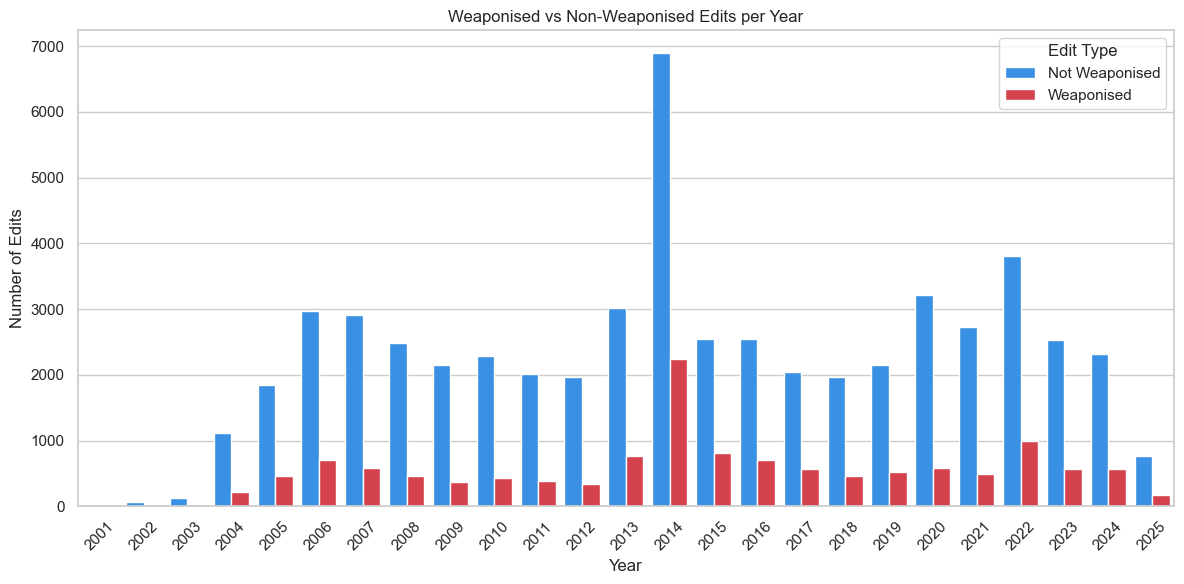

weaponised,Not Weaponised,Weaponised
year,,
2001,8.0,NaN
2002,64.0,10.0
2003,130.0,32.0
2004,1123.0,224.0
2005,1839.0,454.0
2006,2975.0,712.0
2007,2910.0,587.0
2008,2479.0,457.0
2009,2147.0,371.0


In [138]:
def plot_weap_vs_not_weap_per_year(dataframe, wanna_save=False):
    # Extract year
    df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

    # Group counts
    df_counts = (
        df.groupby(["year", "weaponised"])
          .size()
          .reset_index(name="count")
    )

    custom_palette = {
        "Weaponised": "#ed2939",      # red
        "Not Weaponised": "#1e90ff",  # royal blue
    }

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df_counts,
        x="year",
        y="count",
        hue="weaponised",
        palette=custom_palette
    )

    plt.title("Weaponised vs Non-Weaponised Edits per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Edits")
    plt.legend(title="Edit Type")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            "../../plots/Full Database/Weaponised vs Non-Weaponised Edits per Year.png",
            dpi=300,
            bbox_inches='tight'
        )
    plt.show()

    return df_counts.pivot(index="year", columns="weaponised", values="count")

df_counts = plot_weap_vs_not_weap_per_year(df_preprocessed, wanna_save=False)
df_counts

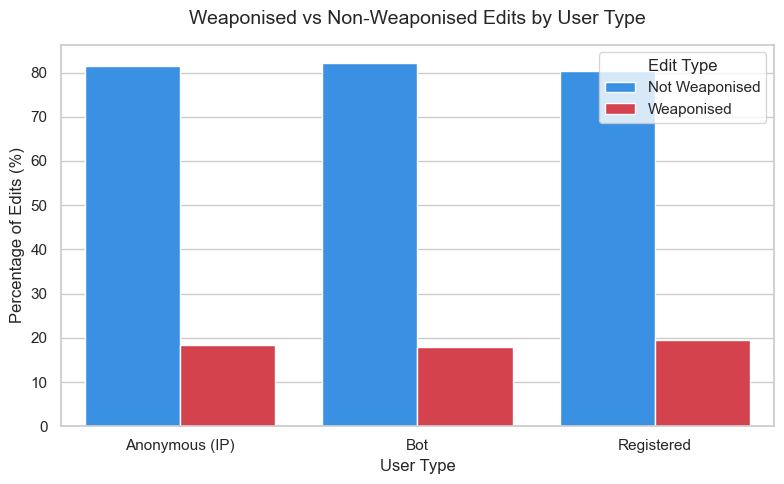

weaponised,Not Weaponised,Weaponised
user_type,,
Anonymous (IP),14532,3286
Bot,2404,522
Registered,39522,9636


In [139]:
def plot_weap_vs_not_weap_per_user_type(dataframe, wanna_save=False):

    comparison = (
        dataframe.groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="count")
    )
    
    # Compute total edits per user type and percentage of weaponised edits
    totals = comparison.groupby("user_type")["count"].sum().reset_index(name="total")
    comparison = comparison.merge(totals, on="user_type")
    comparison["percentage"] = (comparison["count"] / comparison["total"]) * 100
    
    custom_palette = {
        "Weaponised": "#ed2939",      # red
        "Not Weaponised": "#1e90ff",   # royal blue
    }
    
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=comparison,
        x="user_type",
        y="percentage",
        hue="weaponised",
        palette=custom_palette
    )
    
    plt.title("Weaponised vs Non-Weaponised Edits by User Type", fontsize=14, pad=15)
    plt.xlabel("User Type", fontsize=12)
    plt.ylabel("Percentage of Edits (%)", fontsize=12)
    plt.legend(title="Edit Type")
    plt.tight_layout()
    fig_title = 'Weaponised vs Non-Weaponised Edits by User Type'
    if wanna_save:
        plt.savefig(f"../../plots/Full Database/{fig_title}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return comparison.pivot(columns='weaponised', index='user_type', values='count')

comparison = plot_weap_vs_not_weap_per_user_type(df_preprocessed, False)
comparison

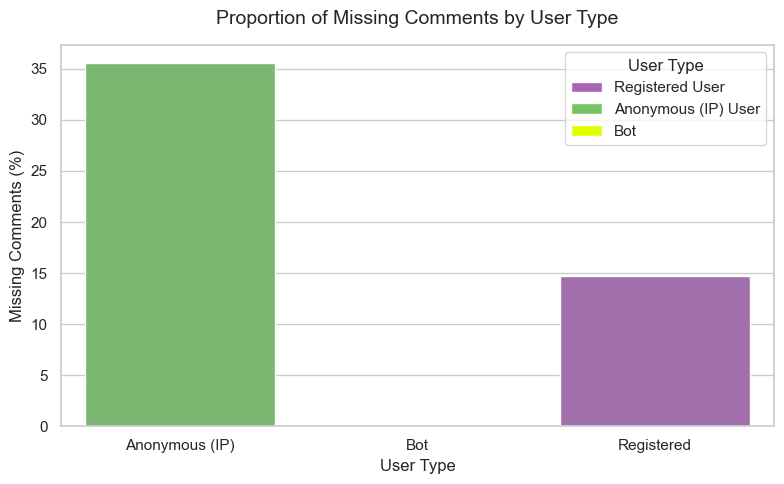

In [140]:
def plot_missing_comment_per_user_type(dataframe, wanna_save=False):

    missing = (
        dataframe[dataframe["comment"].isna()]
        .groupby("user_type")
        .size()
        .reset_index(name="missing_count")
    )
    
    total = (
        dataframe.groupby("user_type")
        .size()
        .reset_index(name="total_count")
    )
    comparison = missing.merge(total, on="user_type", how="right").fillna(0)
    comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100
    
    comparison = comparison[comparison["user_type"].isin(["Registered", "Anonymous (IP)", "Bot"])]
    
    custom_palette = {
        "Registered": "#a865b5",      
        "Anonymous (IP)": "#74c365", 
        "Bot": "#dfff00"
    }
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    
    sns.barplot(
        data=comparison,
        x="user_type",
        y="missing_percentage",
        hue='user_type',
        palette=custom_palette
    )
    
    plt.title("Proportion of Missing Comments by User Type", fontsize=14, pad=15)
    plt.xlabel("User Type", fontsize=12)
    plt.ylabel("Missing Comments (%)", fontsize=12)
    plt.tight_layout()
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="#a865b5", label="Registered User"),
        Patch(facecolor="#74c365", label="Anonymous (IP) User"),
        Patch(facecolor="#dfff00", label="Bot")
    ]
    plt.legend(
        handles=legend_elements,
        title="User Type",
        loc="upper right",
        frameon=True
    )
    fig_title = "Proportion of Missing Comments by User Type"
    if wanna_save:
        plt.savefig(f"../../plots/Full Database/{fig_title}.png", dpi=300, bbox_inches="tight")
        
    plt.show()

plot_missing_comment_per_user_type(df_preprocessed, False)

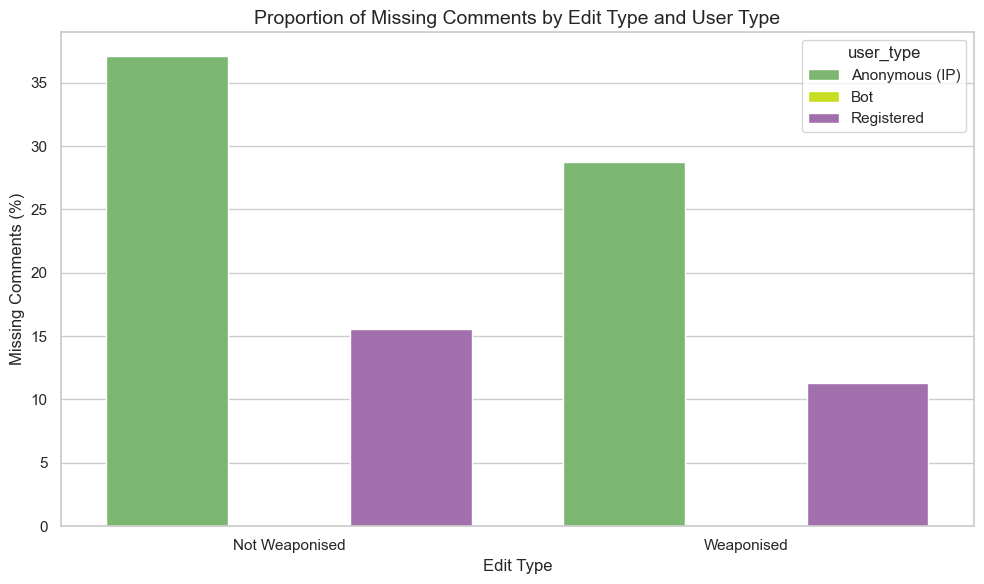

In [141]:
def plot_missing_comment_user_type_edit_type(dataframe, wanna_save=False):
    
    custom_palette = {
        "Registered": "#a865b5",
        "Anonymous (IP)": "#74c365",
        "Bot": "#dfff00"
    }
    
    missing = (
        dataframe[dataframe["comment"].isna()]
        .groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="missing_count")
    )
    
    # Total edits per edit type
    total = (
        dataframe.groupby(["user_type", "weaponised"])
        .size()
        .reset_index(name="total_count")
    )
    
    # Merge & compute proportions
    comparison = total.merge(missing, on=["user_type", "weaponised"], how="left")
    comparison["missing_count"] = comparison["missing_count"].fillna(0)
    comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    sns.barplot(
        data=comparison,
        x="weaponised",
        y="missing_percentage",
        hue="user_type",
        palette=custom_palette
    )
    
    plt.title("Proportion of Missing Comments by Edit Type and User Type", fontsize=14)
    plt.xlabel("Edit Type", fontsize=12)
    plt.ylabel("Missing Comments (%)", fontsize=12)
    plt.tight_layout()
    
    
    fig_title = "Proportion of Missing Comments by Edit Type and User Type"
    if wanna_save:
        plt.savefig(f"../../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_missing_comment_user_type_edit_type(df_preprocessed, False)

In [142]:
missing = (
    df_preprocessed[df_preprocessed["comment"].isna()]
    .groupby(["user_type", 'weaponised'])
    .size()
    .reset_index(name="missing_count")
)

missing.pivot(columns='weaponised', index='user_type', values='missing_count')

weaponised,Not Weaponised,Weaponised
user_type,,
Anonymous (IP),5394,945
Registered,6161,1090


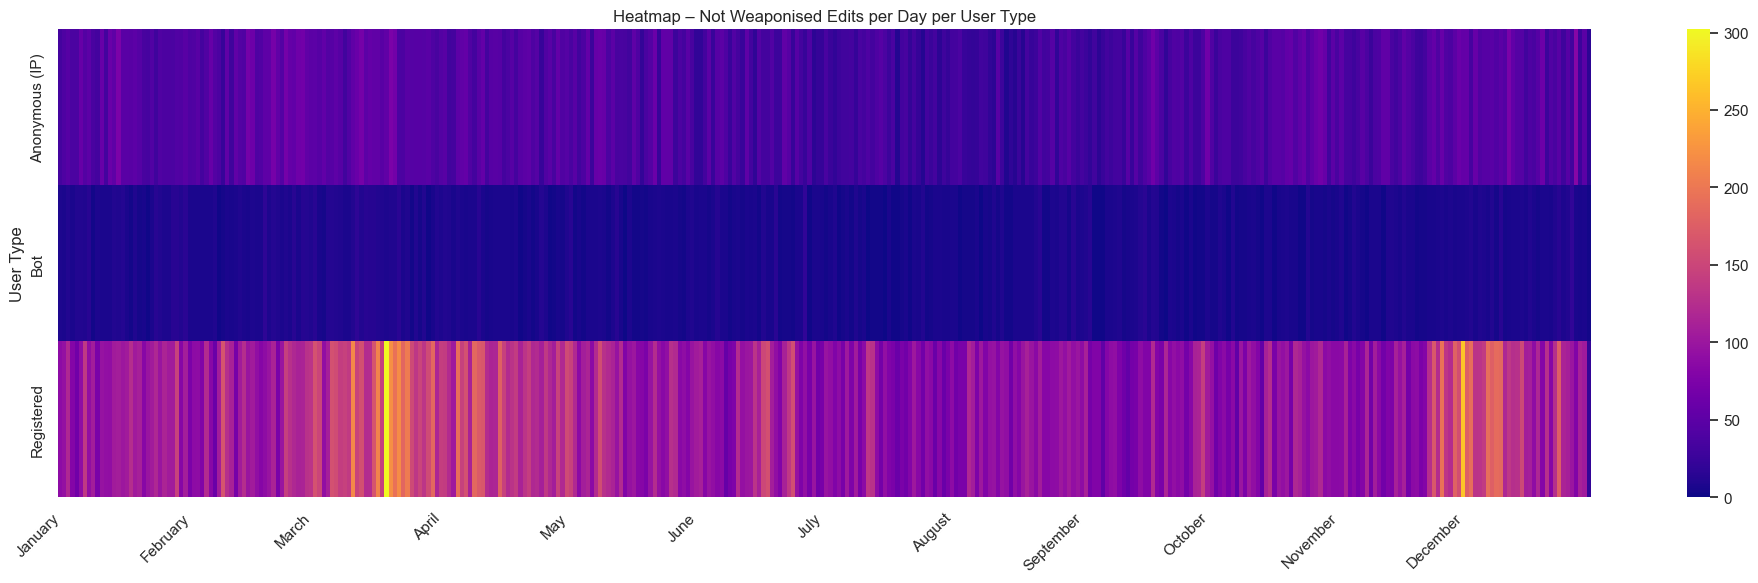

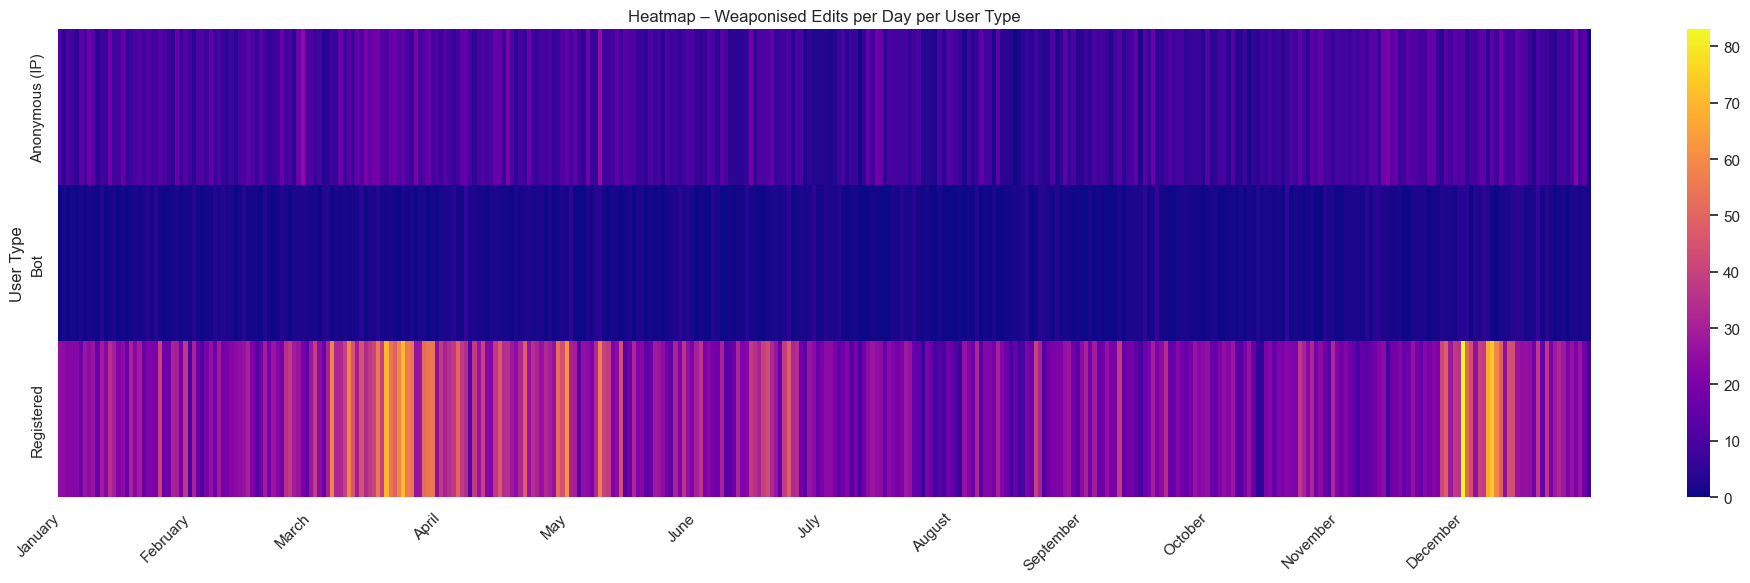

In [143]:
def plot_heatmaps(dataframe, wanna_save=False):

    dataframe = dataframe.copy()
    dt = pd.to_datetime(df["date"], errors="coerce")
    dataframe["date"] = dt.dt.date
    dataframe["doy"] = dt.dt.dayofyear
    
    df_not_weap = dataframe[dataframe["weaponised"] == "Not Weaponised"].copy()
    df_weap     = dataframe[dataframe["weaponised"] != "Not Weaponised"].copy()

    daily_not_weap = (
        df_not_weap.groupby(["user_type", "date"])
        .size()
        .reset_index(name="count")
    )

    daily_weap = (
        df_weap.groupby(["user_type", "date"])
        .size()
        .reset_index(name="count")
    )


    daily_not_weap["doy"] = pd.to_datetime(daily_not_weap["date"]).dt.dayofyear
    daily_weap["doy"]     = pd.to_datetime(daily_weap["date"]).dt.dayofyear


    hm_not_weap = daily_not_weap.pivot_table(
        index="user_type", columns="doy", values="count", aggfunc="sum"
    ).fillna(0)

    hm_weap = daily_weap.pivot_table(
        index="user_type", columns="doy", values="count", aggfunc="sum"
    ).fillna(0)

    
    hm_not_weap = hm_not_weap.reindex(columns=range(1, 367), fill_value=0)
    hm_weap     = hm_weap.reindex(columns=range(1, 367), fill_value=0)

    
    month_starts = [pd.Timestamp(f"2024-{m:02d}-01").dayofyear for m in range(1, 13)]
    month_names = [calendar.month_name[m] for m in range(1, 13)]

    
    plt.figure(figsize=(20, 6))
    sns.heatmap(hm_not_weap, cmap="plasma", cbar=True)

    plt.xticks(month_starts, month_names, rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("User Type")
    plt.title("Heatmap – Not Weaponised Edits per Day per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig("../../plots/Full Database/Heatmap_Not_Weaponised.png",
                    dpi=300, bbox_inches="tight")
    plt.show()

    
    plt.figure(figsize=(20, 6))
    sns.heatmap(hm_weap, cmap="plasma", cbar=True)

    plt.xticks(month_starts, month_names, rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("User Type")
    plt.title("Heatmap – Weaponised Edits per Day per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig("../../plots/Full Database/Heatmap_Weaponised.png",
                    dpi=300, bbox_inches="tight")
    plt.show()

    return hm_not_weap, hm_weap

hm_not, hm_weap = plot_heatmaps(df_preprocessed)

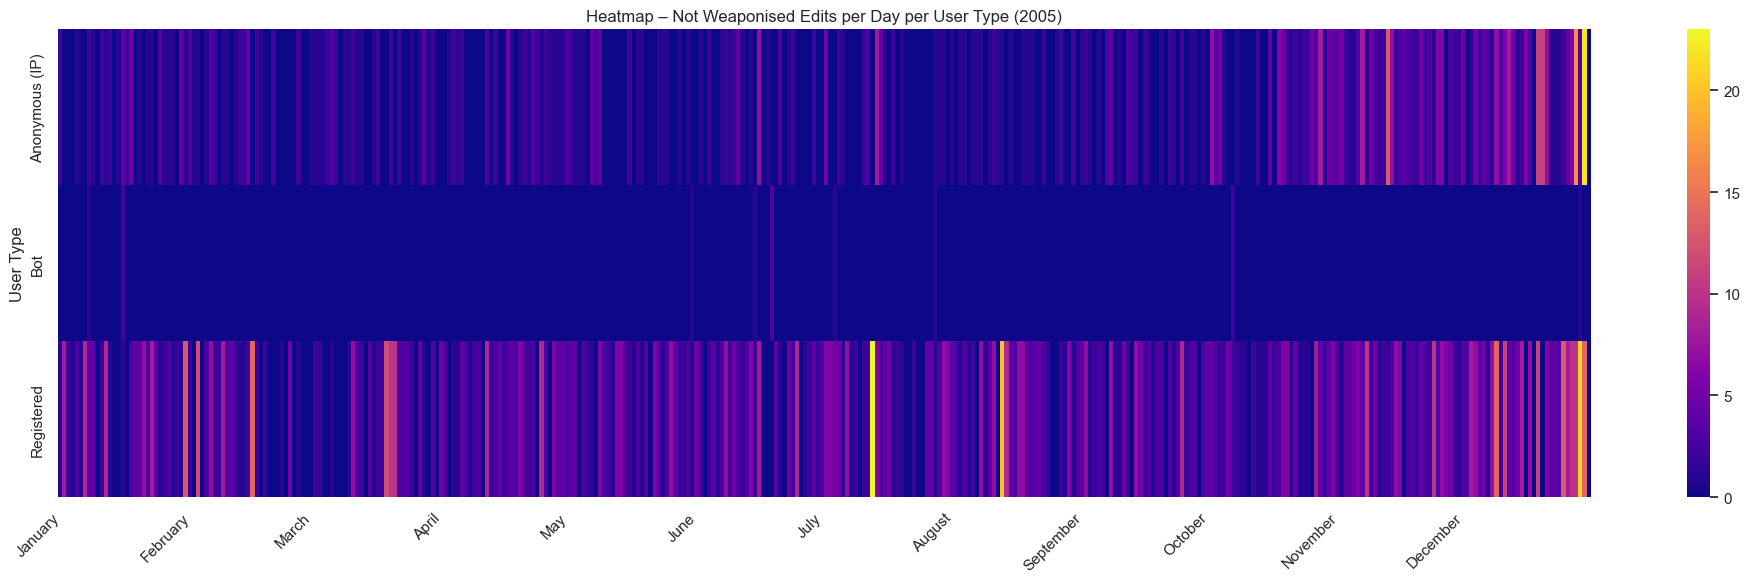

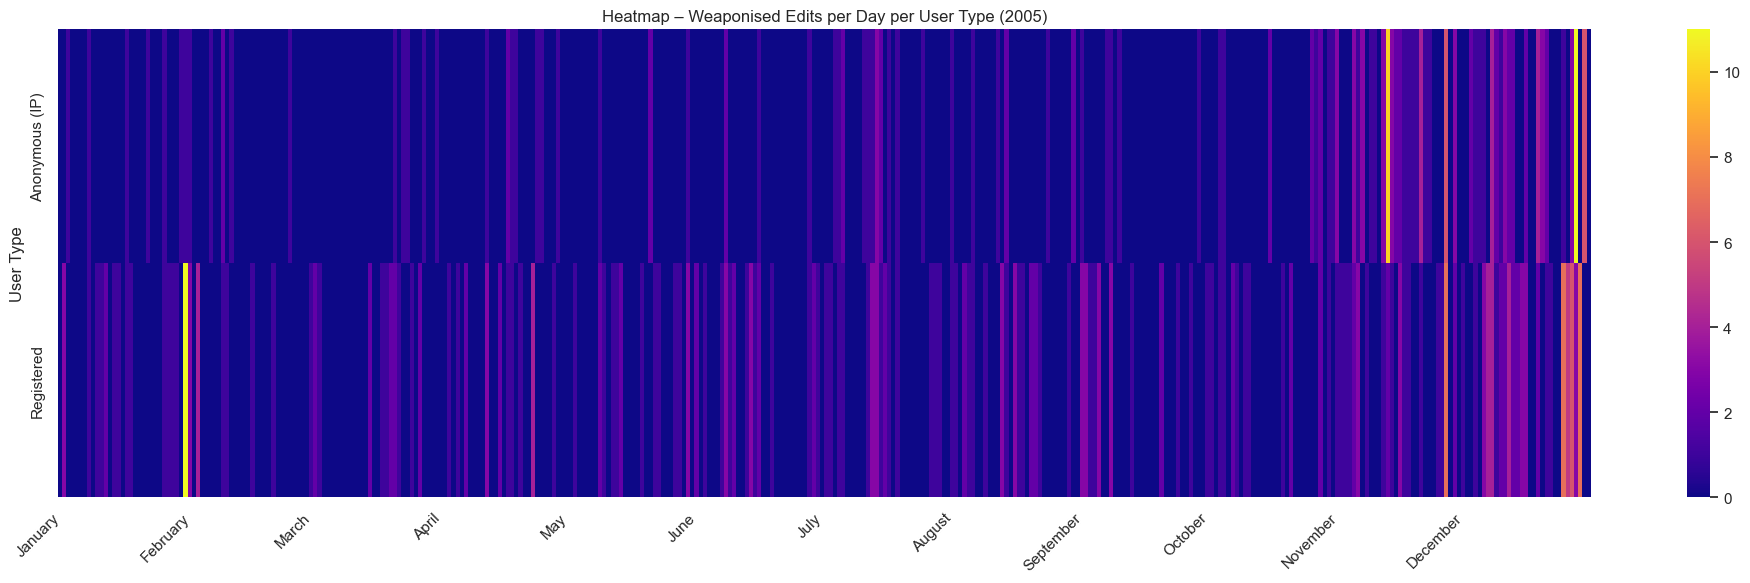

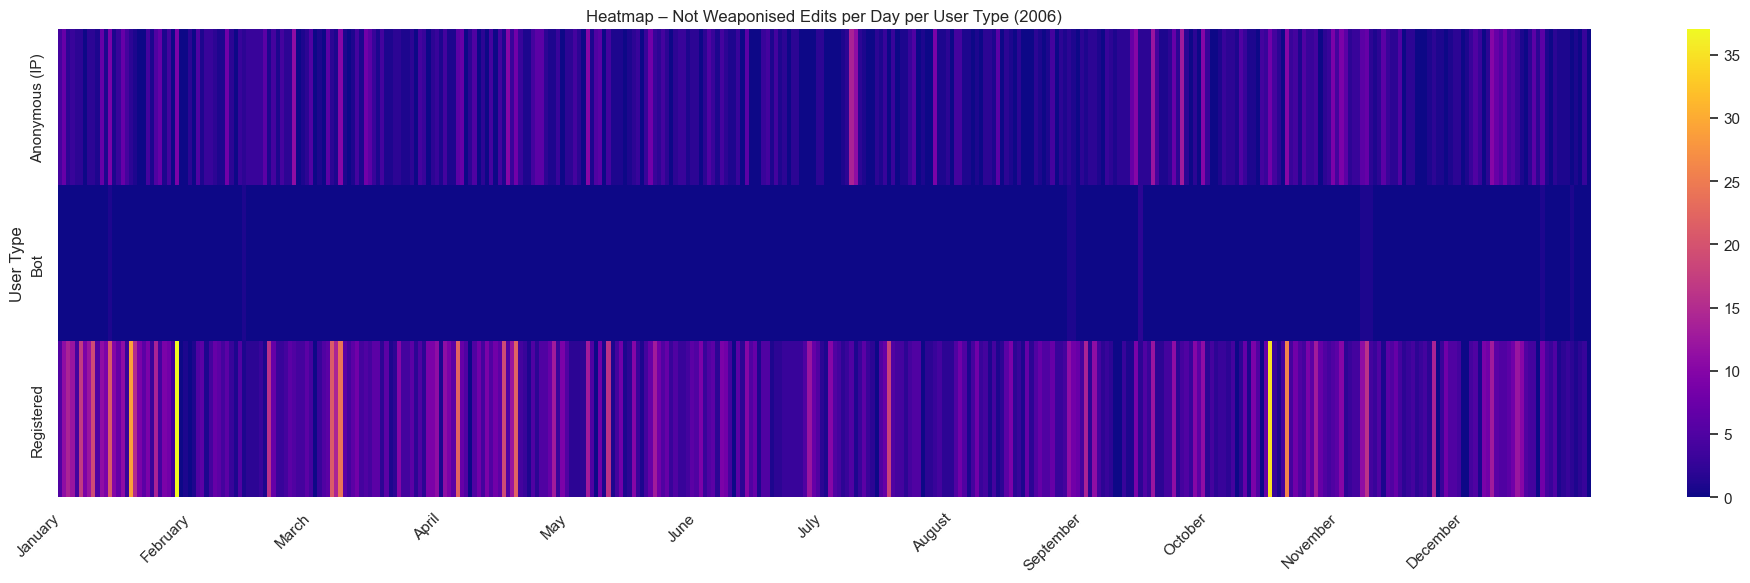

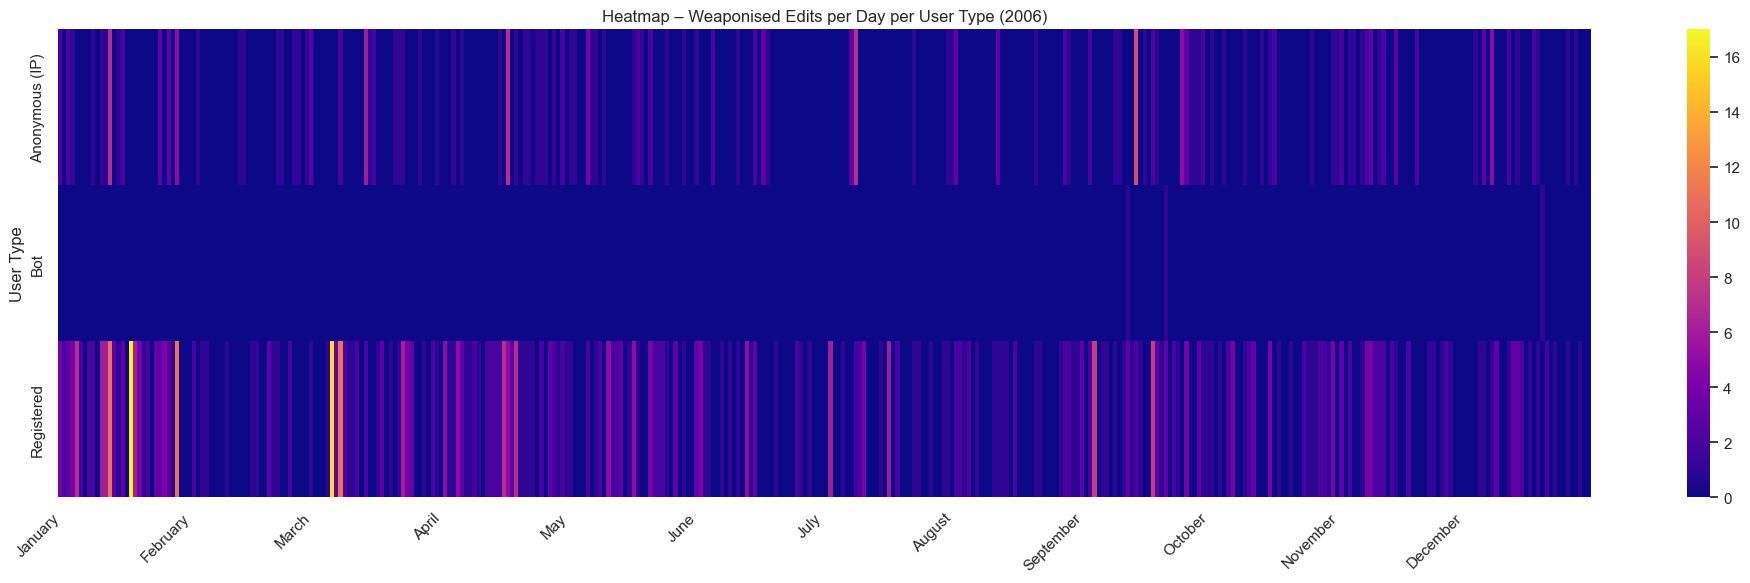

In [167]:
def plot_heatmaps_years(dataframe, years="all", wanna_save=False):

    dataframe = dataframe.copy()
    dt = pd.to_datetime(dataframe["date"], errors="coerce")
    dataframe["date"] = dt.dt.date
    dataframe["doy"] = dt.dt.dayofyear
    dataframe["year"] = dt.dt.year

    # The idea is to be able to choose to plot a specific year, all the years from 2001 to 2025 or a subset (2014, 2015, 2016)
    # all years in the range 2001–2025
    if years == "all":
        selected_years = list(range(2001, 2026))
    # single int
    elif isinstance(years, int):
        selected_years = [years]
    # list/tuple of ints
    else:
        selected_years = list(years)

    dataframe = dataframe[dataframe["year"].isin(selected_years)]

    month_starts = [pd.Timestamp(f"2024-{m:02d}-01").dayofyear for m in range(1, 13)]
    month_names = [calendar.month_name[m] for m in range(1, 13)]

    results = {}

    for year in selected_years:
        df_y = dataframe[dataframe["year"] == year]

        if df_y.empty:
            print(f"No data for year {year}. So we continue...")
            continue

        df_not = df_y[df_y["weaponised"] == "Not Weaponised"]
        df_weap = df_y[df_y["weaponised"] != "Not Weaponised"]

        daily_not = (
            df_not.groupby(["user_type", "date"])
            .size()
            .reset_index(name="count")
        )
        daily_weap = (
            df_weap.groupby(["user_type", "date"])
            .size()
            .reset_index(name="count")
        )

        daily_not["doy"] = pd.to_datetime(daily_not["date"]).dt.dayofyear
        daily_weap["doy"] = pd.to_datetime(daily_weap["date"]).dt.dayofyear

       
        hm_not = daily_not.pivot_table(
            index="user_type", columns="doy", values="count", aggfunc="sum"
        ).fillna(0)

        hm_weap = daily_weap.pivot_table(
            index="user_type", columns="doy", values="count", aggfunc="sum"
        ).fillna(0)

        hm_not = hm_not.reindex(columns=range(1, 367), fill_value=0)
        hm_weap = hm_weap.reindex(columns=range(1, 367), fill_value=0)

        if hm_not.empty:
            print(f"No NOT weaponised data for year {year}. Skipping heatmap…")
            
        else:
            plt.figure(figsize=(20, 6))
            sns.heatmap(hm_not, cmap="plasma", cbar=True)
    
            plt.xticks(month_starts, month_names, rotation=45, ha="right")
            plt.ylabel("User Type")
            plt.xlabel("")
            plt.title(f"Heatmap – Not Weaponised Edits per Day per User Type ({year})")
            plt.tight_layout()
    
            if wanna_save:
                plt.savefig(
                    f"../../plots/Full Database/Heatmap_Not_Weaponised_{year}.png",
                    dpi=300,
                    bbox_inches="tight"
                )
            plt.show()

        if hm_weap.empty:
            print(f"No weaponised data for year {year}. Skipping heatmap…")
        
        else:
            plt.figure(figsize=(20, 6))
            sns.heatmap(hm_weap, cmap="plasma", cbar=True)

            plt.xticks(month_starts, month_names, rotation=45, ha="right")
            plt.ylabel("User Type")
            plt.xlabel("")
            plt.title(f"Heatmap – Weaponised Edits per Day per User Type ({year})")
            plt.tight_layout()
    
            if wanna_save:
                plt.savefig(
                    f"../../plots/Full Database/Heatmap_Weaponised_{year}.png",
                    dpi=300,
                    bbox_inches="tight"
                )
            plt.show()

        results[year] = (hm_not, hm_weap)

plot_heatmaps_years(df_preprocessed, years=[2005, 2006], wanna_save=True)

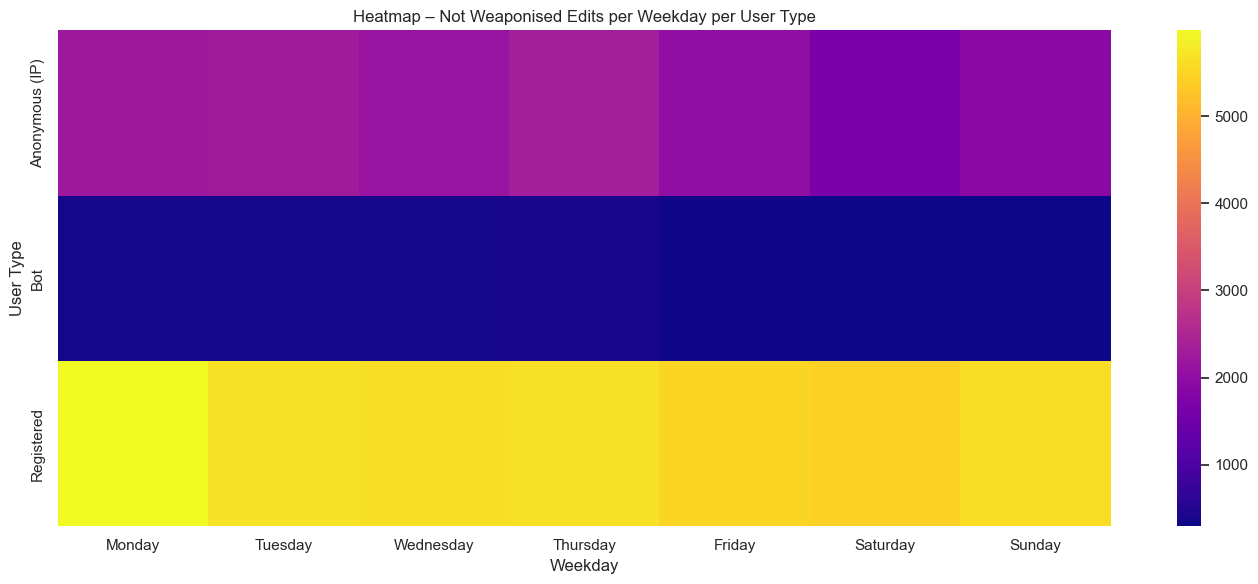

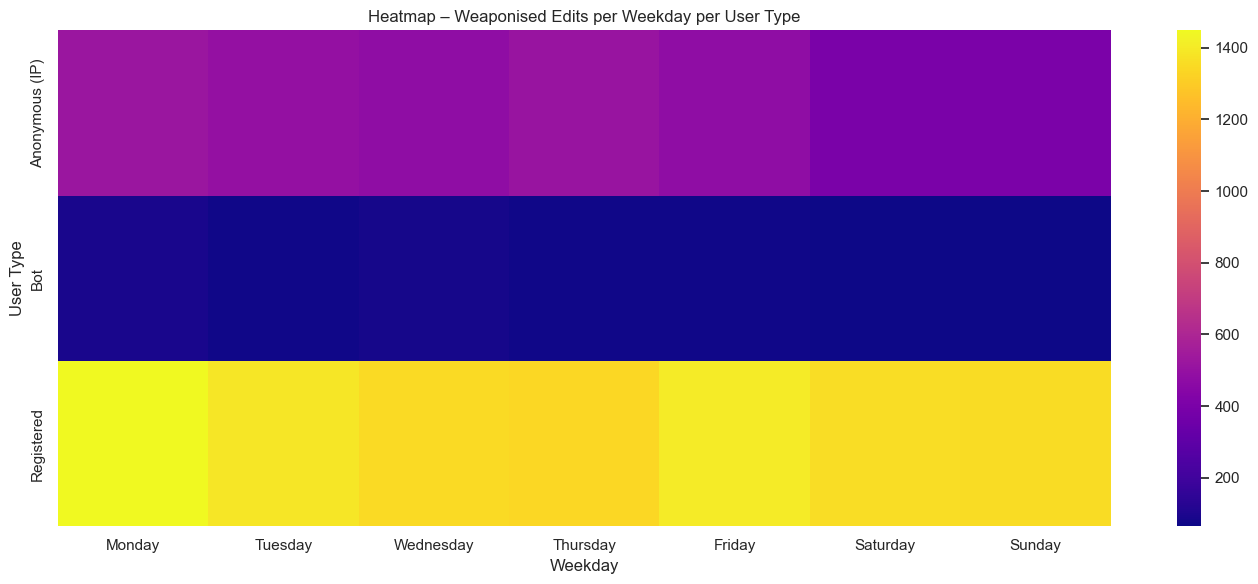

(weekday_name    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
 user_type                                                                     
 Anonymous (IP)    2215     2253       2129      2325    2015      1684    1911
 Bot                369      360        376       386     318       303     292
 Registered        5986     5675       5632      5666    5513      5446    5604,
 weekday_name    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
 user_type                                                                     
 Anonymous (IP)     521      495        480       513     477       398     402
 Bot                 91       71         82        71      75        65      67
 Registered        1448     1386       1350      1337    1402      1357    1356)

In [146]:
def plot_heatmap_weekdays(dataframe, wanna_save=False):
    
    df = dataframe.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["weekday"] = df["date"].dt.weekday          # 0=Mon, 6=Sun
    df["weekday_name"] = df["date"].dt.day_name()

   
    df_not = df[df["weaponised"] == "Not Weaponised"].copy()
    df_weap = df[df["weaponised"] != "Not Weaponised"].copy()

    
    daily_not = (
        df_not.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

    daily_weap = (
        df_weap.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

   
    hm_not = daily_not.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    hm_weap = daily_weap.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    
    ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    hm_not = hm_not.reindex(columns=ordered_days, fill_value=0)
    hm_weap = hm_weap.reindex(columns=ordered_days, fill_value=0)

    
    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_not, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title("Heatmap – Not Weaponised Edits per Weekday per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            "../../plots/Full Database/Heatmap_Weekday_Not_Weaponised.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_weap, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title("Heatmap – Weaponised Edits per Weekday per User Type")
    plt.tight_layout()

    if wanna_save:
        plt.savefig(
            "../../plots/Full Database/Heatmap_Weekday_Weaponised.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    return hm_not, hm_weap

plot_heatmap_weekdays(df_preprocessed)

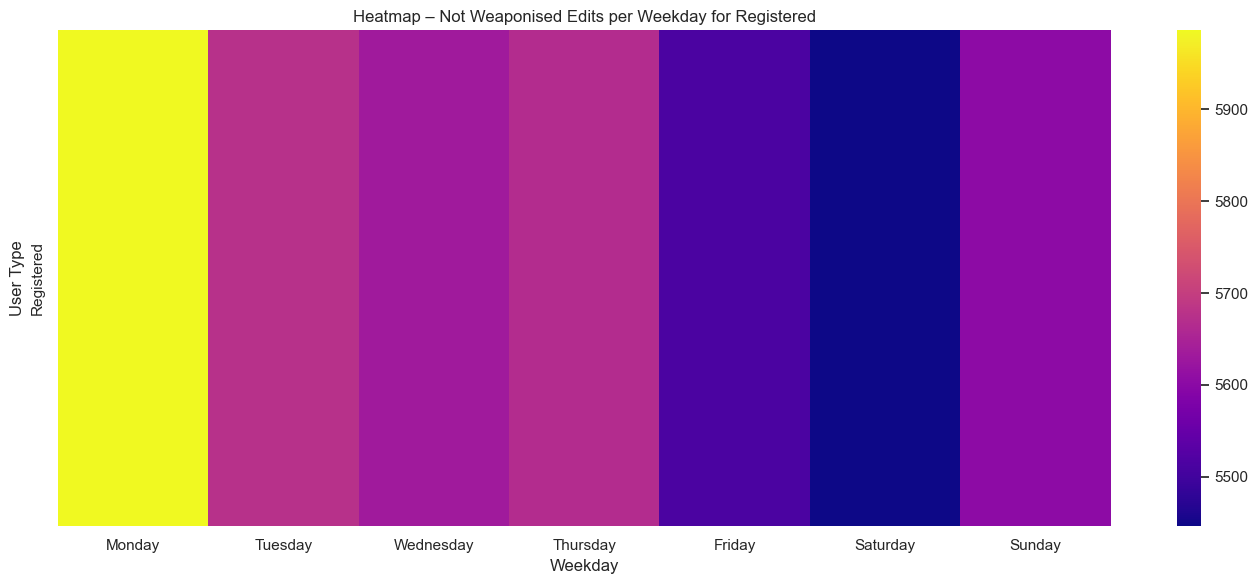

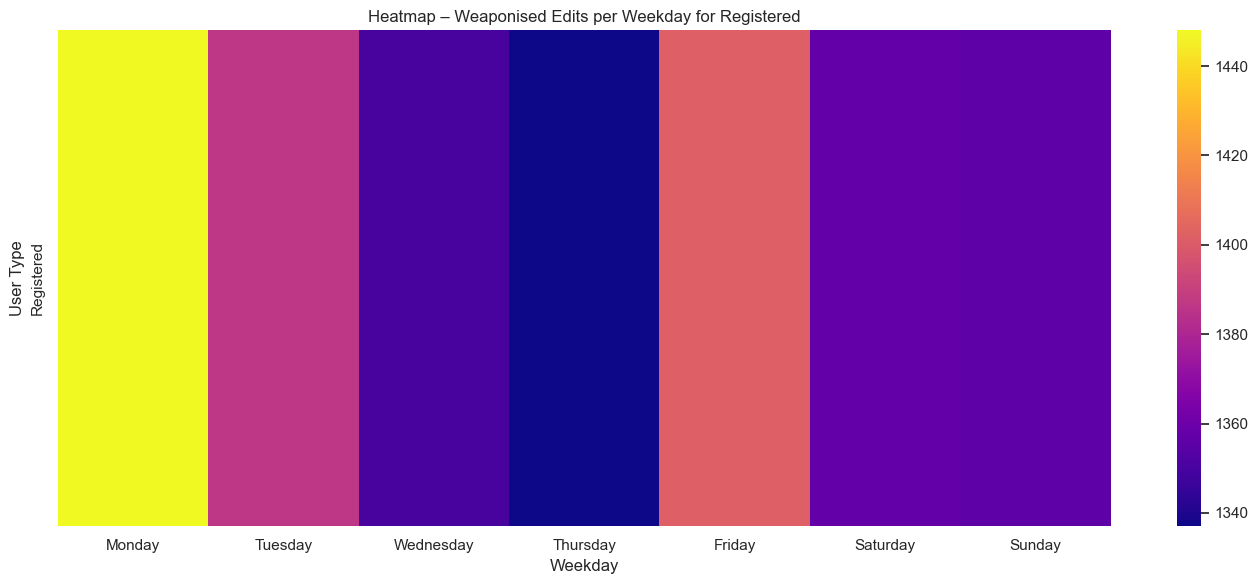

(weekday_name  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
 user_type                                                                   
 Registered      5986     5675       5632      5666    5513      5446    5604,
 weekday_name  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
 user_type                                                                   
 Registered      1448     1386       1350      1337    1402      1357    1356)

In [165]:
def plot_heatmap_weekdays(dataframe, user_type = 'Anonymous (IP)', wanna_save=False):
    
    df = dataframe.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["weekday"] = df["date"].dt.weekday          # 0=Mon, 6=Sun
    df["weekday_name"] = df["date"].dt.day_name()
    df = df[df['user_type'] == user_type]
   
    df_not = df[df["weaponised"] == "Not Weaponised"].copy()
    df_weap = df[df["weaponised"] != "Not Weaponised"].copy()

    
    daily_not = (
        df_not.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

    daily_weap = (
        df_weap.groupby(["user_type", "weekday_name"])
        .size()
        .reset_index(name="count")
    )

   
    hm_not = daily_not.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    hm_weap = daily_weap.pivot_table(
        index="user_type",
        columns="weekday_name",
        values="count",
        aggfunc="sum"
    ).fillna(0)

    
    ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    hm_not = hm_not.reindex(columns=ordered_days, fill_value=0)
    hm_weap = hm_weap.reindex(columns=ordered_days, fill_value=0)

    
    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_not, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title(f"Heatmap – Not Weaponised Edits per Weekday for {user_type}")
    plt.tight_layout()
    title_not = f"Heatmap – Not Weaponised Edits per Weekday for {user_type}"

    if wanna_save:
        plt.savefig(
            f"../../plots/Full Database/{title_not}.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.heatmap(hm_weap, cmap="plasma", cbar=True)
    plt.xlabel("Weekday")
    plt.ylabel("User Type")
    plt.title(f"Heatmap – Weaponised Edits per Weekday for {user_type}")
    plt.tight_layout()
    title_weap = f"Heatmap – Weaponised Edits per Weekday for {user_type}"

    if wanna_save:
        plt.savefig(
            f"../../plots/Full Database/{title_weap}.png",
            dpi=300, bbox_inches="tight"
        )
    plt.show()

    return hm_not, hm_weap

plot_heatmap_weekdays(df_preprocessed, 'Registered', True)

In [150]:
df_preprocessed['user_type'].unique()

array(['Registered', 'Anonymous (IP)', 'Bot'], dtype=object)

In [157]:
df_preprocessed.to_csv('../../datas/final/full_db_preprocess.csv', index=False)